### Mean-Variance Potfolio Optimization with Elastic Net Penalty

Utilizes Pylops: python library of linear operators for inverse problems

In [2]:
import pylops 
import numpy as np
import pandas as pd
import scipy.optimize
import matplotlib.pyplot as plt

In [93]:
equity_data=pd.read_csv('equity_data_2021.csv')
equity_data.index=equity_data['Date']
equity_data=equity_data.drop(columns=['Date'])

returns=np.log(equity_data/equity_data.shift(1))
returns=returns.fillna(0)
returns

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-03,-0.000042,0.005995,0.002209,0.015528,0.017152,0.004605,0.015430,-0.007763,0.018621,0.010804,...,0.018536,-0.006299,-0.010893,-0.006716,0.012120,-0.000858,0.019668,0.006908,-0.001184,0.004588
2018-01-04,0.012987,0.004674,-0.001699,-0.005719,0.017364,0.011771,-0.010002,0.016702,0.011970,0.009507,...,0.010100,0.007782,0.005400,-0.007822,0.006654,0.010129,0.019567,-0.001442,0.004138,0.005946
2018-01-05,0.007762,0.012782,0.002886,0.017258,0.015290,0.008215,0.026102,-0.006697,0.011504,-0.000592,...,0.006392,0.009235,0.006649,-0.007028,-0.001876,0.005811,0.015456,0.009892,0.000393,0.011379
2018-01-08,-0.003248,0.004751,-0.002886,-0.016152,0.026725,0.007960,0.003910,-0.002242,-0.001620,-0.003048,...,-0.005401,0.000000,-0.013403,0.007452,0.003605,0.001689,0.009901,0.001903,-0.004927,0.011924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.009839,0.023050,0.016393,0.009869,0.015830,0.029368,0.004441,0.009581,0.014051,0.017572,...,0.010935,0.025787,-0.014734,0.003148,0.006701,0.019536,0.040250,0.006436,0.010369,0.016360
2021-12-28,0.005306,0.009869,-0.007023,-0.000149,-0.001090,-0.000144,0.018469,0.012933,-0.014507,-0.000894,...,-0.001423,0.009103,-0.012871,0.011901,0.010344,-0.000217,-0.014971,0.003125,0.001586,-0.009210
2021-12-29,0.004325,0.003151,0.005113,0.007192,0.012235,0.000361,0.007323,0.001195,-0.000123,0.007853,...,-0.001216,0.008640,-0.017266,0.005015,-0.001340,0.004916,0.006342,0.000156,0.005373,0.011317


### Computation of Naive mean and covariance estimation from sample

In [94]:
returns_mean=returns.mean()
returns_cov=pd.DataFrame(np.cov(returns.T))

Text(0.5, 1.0, 'Distribution of Average Log Return ')

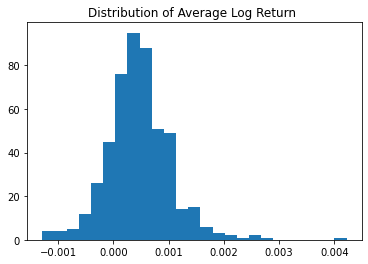

In [95]:
bins=plt.hist(returns.mean(),bins=25)
plt.title("Distribution of Average Log Return ")

### Application of Sparse Solver Split Bregman Operator



In [205]:
def qp(cov,mean,w,d,b,beta,lambda1):
    """ Inner optimization problem using unconstrained optimization 
    """
    
    x0=w
    def objective_val(w,cov,mean,d,b,beta,lambda1):
        obj=np.dot(np.dot(w,cov),w)-np.dot(w,mean)
        
        l2_pen=np.sum((d-beta*w-b)**2)

        return obj+lambda1*l2_pen/2

    res=scipy.optimize.minimize(objective_val,x0=w,args=(returns_cov,returns_mean,d,b,beta,lambda1),method='CG',options={'maxiter':100},tol=1e-5)
    
    w=res.x
    
    return w

def shrinkage(w,d,b,lambda1,beta):
    """ Shrinkage operator; second optimization routine
    """
    
    x=beta*w+b
    
    # elementwise max
    obj=np.fmax([np.abs(x)-(1/lambda1)],[np.zeros(len(w))])
    signed_obj=np.sign(x)*obj

    return signed_obj[0]

def split_bregman(cov,mean,beta=None,tol=1e-12,maxiter=550):
    """ Split Bregman Optimization Routine
    """

    error=1
    n=len(mean)
    if beta is None:
        beta=np.ones(n)
    
    b=np.zeros(n)
    w=np.zeros(n)
    d=np.zeros(n)
    
    
    lambda1=1e-2
    
    i=0
    while error>tol:
        if i>maxiter:
            print("MaxIter Achieved")
            
        
        if i%100==0:
            print(f"{i}-th iteration with error of {error}")
        
        w_old=w
        w=qp(cov,mean,w_old,d,b,beta,lambda1)
        error=np.sum((w-w_old)**2)
        print(error)
        
        d=shrinkage(w,d,b,lambda1,beta)
        b=b+w-d       
        i+=1
    


    unit_w=w/np.linalg.norm(w,ord=1)
    return np.round(unit_w,4)



In [206]:
w=split_bregman(returns_mean,returns_cov,tol=1e-8,maxiter=100)

0-th iteration with error of 1
0.6178978840559652
0.4003407156573521
0.01303996203082967
0.0023307522173951923
0.0008646745767093138
0.00046663536325338236
0.00025330603862358097
0.00016155484752212285
8.388619999403197e-05
5.075542503048154e-05
2.8992719393311336e-05
1.2839604347036008e-05
1.5422262445400162e-05
5.574375835157952e-06
3.727187427677634e-06
3.2359234242103353e-06
2.7476763191284905e-07
4.666887886315623e-06
1.837427667665194e-07
4.880822073136338e-07
3.335612711038177e-06
0.0


In [207]:
print(w)


[0.0017 0.0016 0.0015 0.0014 0.0016 0.0019 0.0013 0.0017 0.002  0.002
 0.0018 0.0022 0.0022 0.0018 0.0018 0.0012 0.0028 0.0024 0.0016 0.0029
 0.002  0.0012 0.0018 0.0018 0.0018 0.0013 0.0014 0.0016 0.0025 0.0013
 0.0029 0.001  0.0027 0.0028 0.0014 0.0012 0.0032 0.0016 0.0022 0.0014
 0.0021 0.0023 0.0021 0.0015 0.0038 0.002  0.0029 0.0029 0.0023 0.0021
 0.0017 0.0019 0.0014 0.0012 0.0023 0.0015 0.0018 0.002  0.0027 0.0014
 0.0025 0.003  0.0013 0.0011 0.002  0.0022 0.0014 0.0015 0.0013 0.0023
 0.002  0.0032 0.0022 0.0022 0.0021 0.002  0.0012 0.0024 0.0015 0.0016
 0.0012 0.0021 0.0043 0.0017 0.0005 0.003  0.0017 0.0022 0.0037 0.0008
 0.0021 0.0021 0.0013 0.0025 0.0022 0.0025 0.0019 0.0021 0.0022 0.0025
 0.0022 0.0022 0.0014 0.0024 0.0016 0.0019 0.0008 0.0021 0.0021 0.0023
 0.0019 0.0028 0.0031 0.0004 0.0017 0.0011 0.0013 0.0021 0.001  0.0016
 0.0029 0.0008 0.0027 0.001  0.0017 0.0017 0.0019 0.0025 0.0017 0.0017
 0.0011 0.0014 0.0014 0.0022 0.0019 0.0015 0.0022 0.0014 0.0028 0.0016
 0.0022